In [2]:
import argparse
import os
import csv
import numpy as np
from numpy import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
import seaborn as sns
from pathlib import Path

#from sklearn.metris import roc_curve,auc

In [1]:
result_ai = r'..\label_loc.csv'


Threshold of tpr 0.9500 =0.1757, specificity = 0.7165


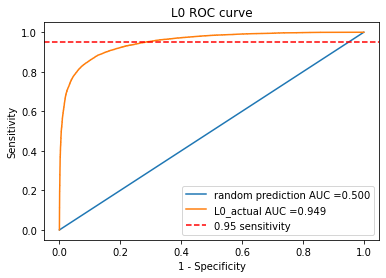

Threshold of tpr 0.9504 =0.0225, specificity = 0.6899


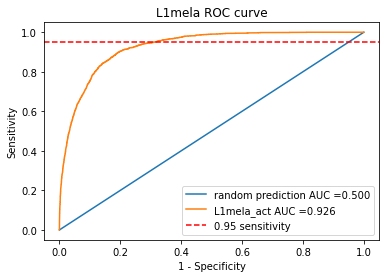

0        1
1        0
2        0
3        0
4        0
        ..
31487    0
31488    2
31489    1
31490    0
31491    0
Name: L1_pred, Length: 31492, dtype: int64
Threshold of tpr 0.9504 =0.0245, specificity = 0.6950


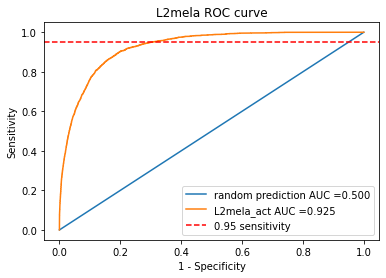

In [3]:
def binary_classification(actual,pred_prob):    
    #claculate ROC curves, Youden's J statistics
    fpr,tpr,thresholds = roc_curve(actual ,pred_prob)
    #print(len(tpr),len(fpr),len(thresholds))
    list_95 = np.where(tpr>=0.95)
    #print(list_95)
    ix = list_95[0][0]
    #print(ix)
    best_threshold = thresholds[ix]
    print('Threshold of tpr %0.4f' % tpr[ix], '=%0.4f,' % (best_threshold),'specificity = %0.4f' % (1-fpr[ix]))
    # random contrast
    r_probs = [0 for _ in range(len(df))] # random prediction as contrast
    r_fpr,r_tpr,_ = roc_curve(actual,r_probs)
    r_auc=roc_auc_score(actual,r_probs)
    # plot roc curve
    name_col = (actual.name).split('_') ## name for title 
    name_col_pred = name_col[0] + '_pred'  ## name of column predicted class
    L_auc = roc_auc_score(actual ,pred_prob)
    L_fpr, L_tpr, _ = roc_curve(actual ,pred_prob)
    plt.plot(r_fpr, r_tpr,  label='random prediction AUC =%0.3f' % r_auc)
    plt.plot(L_fpr, L_tpr,  label= str(actual.name)+' AUC =%0.3f' % L_auc)
    plt.axhline(tpr[ix],linestyle='--',color='red',label ='0.95 sensitivity') # x = 0.95
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(str(name_col[0]) + ' ROC curve')
    plt.legend()
    plt.show()
    # output predicted class to df  
    df[name_col_pred] = pred_prob.map(lambda x:0 if x<best_threshold else 1)
    
## split name according to pattern '_'
df= pd.read_csv(result_ai, encoding='UTF-8', index_col=False, delimiter=',')
split_name = df['name'].str.split("_", n=2, expand = True)
# get actual class of each records
df['L0_act']=split_name[0]
df['L1_act']=split_name[1]
temp=split_name[2].str.split('/',n=1,expand=True)
df['L2_act']=temp[0]
#.replace("_"," ")
# change string value of the above columns to the corresponding class label,L0 benign:0, malignant:1,L1 benign:0, iec:1, melanoma:2, nmsc:3 
df['L0_actual'] = df['L0_act'].map(lambda x:0 if x=="benign" else 1)
df['L1mela_act']=df['L1_act'].map(lambda x:1 if x=="melanoma" else 0)
df['L1_actual'] = df['L1_act'].map(lambda x:0 if x=="benign" else(1 if x=="iec" else(2 if x=="melanoma" else 3)))
#L0 classification
binary_classification(df['L0_actual'],df['malignant'])
# melanoma classification
binary_classification(df['L1mela_act'],df['malignant:melanoma'])
# get predicted L1 class in column L1_pred
max_ind_L1=[]
for i in range(0,len(df)):
    max_ind_L1.append(np.argmax(df.iloc[i,3:7]))
df['L1_pred'] = max_ind_L1
print(df['L1_pred'])
# replace all melanoma positive in column'L1mela_pred' to 2 in df['L1_pred]
df['L1_pred']=np.where(df['L1mela_pred']==1, 2 , df['L1_pred'])

# change L2_actual classification into 1-9 numbers
L2_actual=[]
for i in range(0,len(df)):
        if 'vascular' in df.iloc[i,48]:
            L2_actual.append(1)
        elif 'keratinocytic' in df.iloc[i,48]:
            L2_actual.append(2)
        elif 'nevus' in df.iloc[i,48]:
            L2_actual.append(3)
        elif 'other' in df.iloc[i,48] or 'dermatofibroma' in df.iloc[i,48]:
            L2_actual.append(4)
        elif 'melanoma' in df.iloc[i,48]:
            L2_actual.append(5) 
        elif 'keratosis' in df.iloc[i,48]:
            L2_actual.append(6)
        elif 'scc' in df.iloc[i,48] and 'situ' in df.iloc[i,48]:
            L2_actual.append(7)
        elif 'bcc' in df.iloc[i,48]:
            L2_actual.append(8)
        elif 'scc' in df.iloc[i,48] and 'situ' not in df.iloc[i,48] :
            L2_actual.append(9)
        else:
            L2_actual.append(np.nan)
#print(np.unique(L2_actual))
df['L2_actual'] = L2_actual
df['L2mela_act']=df['L2_actual'].map(lambda x:1 if x==5 else 0)
# group subclasses of L2 by column names, total 9 subclasses "benign_vascular","benign_keratinocytic","benign_other_dermatofibroma","benign_nervus","actinic_keratosis","scc_in_situ","melanoma","bcc","scc"
## benign
vasc_cols = [col for col in df.iloc[:,7:46] if 'vascular' in col]
df['L2_vascular']= df[vasc_cols].sum(axis=1)
keratino_cols = [col for col in df.iloc[:,7:46] if 'keratinocytic' in col]
df['L2_keratino']= df[keratino_cols].sum(axis=1)
nevus_cols = [col for col in df.iloc[:,7:46] if 'nevus' in col]
df['L2_nevus']= df[nevus_cols].sum(axis=1)
other_derma_cols = [col for col in df.iloc[:,7:46] if 'other' in col or 'dermatofibroma' in col]
df['L2_other_dermatofibroma']= df[other_derma_cols].sum(axis=1)
## melanoma
mela_cols = [col for col in df.iloc[:,7:46] if 'melanoma' in col]
df['L2_mela']= df[mela_cols].sum(axis=1)
## other malignant L2 subclasses
kera_cols = [col for col in df.iloc[:,7:46] if 'keratosis' in col]
df['L2_keratosis']= df[kera_cols].sum(axis=1)
scc_situ_cols = [col for col in df.iloc[:,7:46] if 'scc' in col and 'situ' in col]
df['L2_scc_situ']= df[scc_situ_cols].sum(axis=1)
bcc_cols = [col for col in df.iloc[:,7:46] if 'bcc' in col]
df['L2_bcc']= df[bcc_cols].sum(axis=1)
scc_cols = [col for col in df.iloc[:,7:46] if 'scc' in col and 'situ' not in col]
df['L2_scc']= df[scc_cols].sum(axis=1)

## L2 melanoma classification
binary_classification(df['L2mela_act'],df['L2_mela'])
# get predicted L2 class in column L1_pred
max_ind_L2=[]
for i in range(0,len(df)):
    max_ind_L2.append(np.argmax(df.iloc[i,57:66]))
df['L2_pred'] = [x+1 for x in max_ind_L2]
# replace all melanoma positive in column'L1mela_pred' to 2 in df['L1_pred]
df['L2_pred']=np.where(df['L2mela_pred']==1, 5 , df['L2_pred'])

# ouput csv file
col_name = ['name','L0_actual','L0_pred','L1mela_act','L1mela_pred','L1_actual','L1_pred','L1mela_act','L2mela_pred','L2_actual','L2_pred']
df.to_csv(r'..\classanalysis.csv',columns=col_name)



[[12258  4850]
 [  719 13665]]
Accuracy =0.823 ,TPR(Sensitivity) = 0.950  ,TNR(Specificity) =0.717 PPV(Precision) =0.738 distribution_leision =1.355 NPV =0.945 PT(prevalence threshold) =0.353 F1_score =0.831


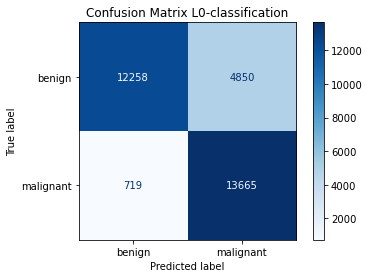

[[20060  9015]
 [  120  2297]]
Accuracy =0.710 ,TPR(Sensitivity) = 0.950  ,TNR(Specificity) =0.690 PPV(Precision) =0.203 distribution_leision =4.925 NPV =0.994 PT(prevalence threshold) =0.364 F1_score =0.335


<Figure size 432x288 with 0 Axes>

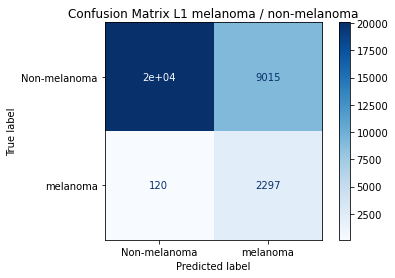

[[20207  8868]
 [  120  2297]]
Accuracy =0.715 ,TPR(Sensitivity) = 0.950  ,TNR(Specificity) =0.695 PPV(Precision) =0.206 distribution_leision =4.861 NPV =0.994 PT(prevalence threshold) =0.362 F1_score =0.338


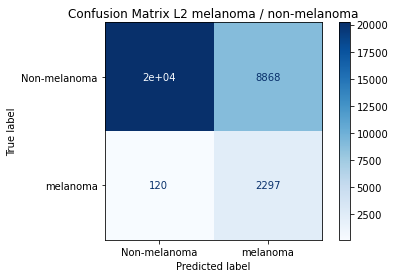

<Figure size 432x288 with 0 Axes>

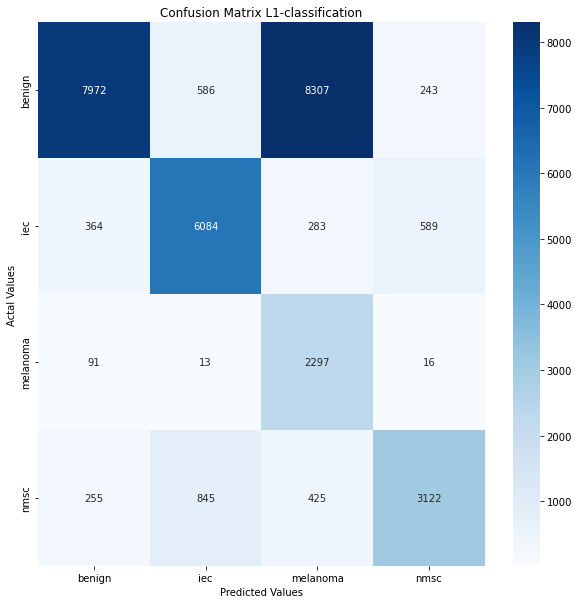

<Figure size 432x288 with 0 Axes>

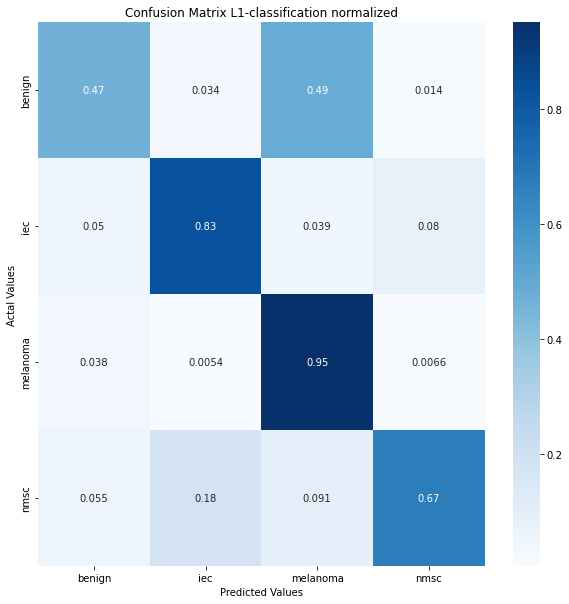

<Figure size 432x288 with 0 Axes>

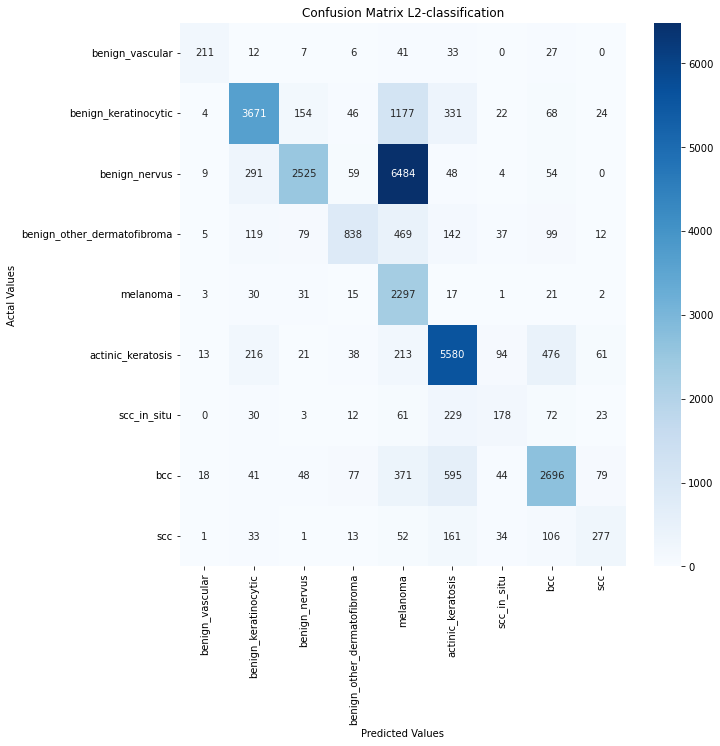

<Figure size 432x288 with 0 Axes>

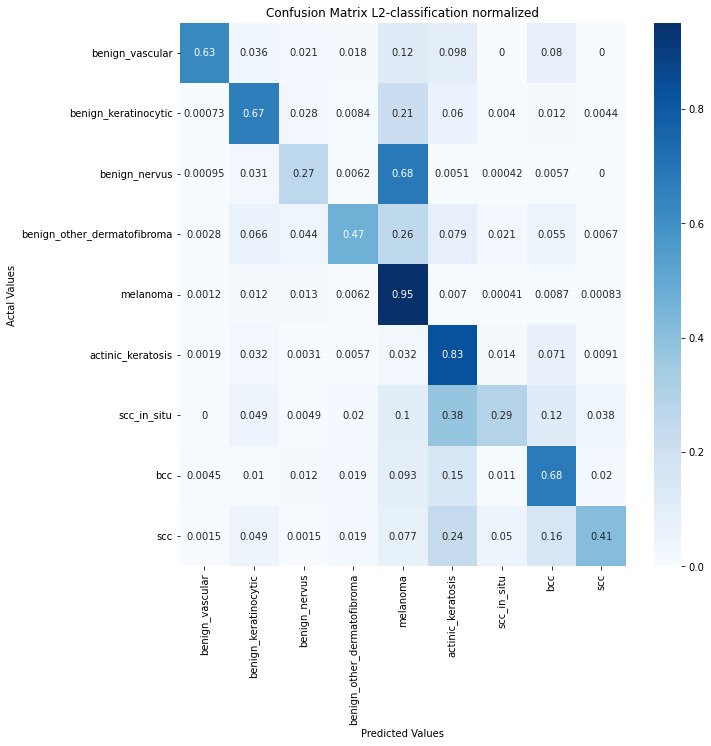

<Figure size 432x288 with 0 Axes>

In [4]:
## for computing sensitivity, specificity ...
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    PPV = TP /(TP+FP)
    distri_leision = 1/PPV
    NPV = TN/(TN+FN)
    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    Accuracy = (TP+TN)/(TP+FP+FN+TN)
    F1_score = 2*(TPR*PPV)/(TPR+PPV)
    PT =np.sqrt(FPR)/(np.sqrt(TPR)+np.sqrt(FPR))
    print('Accuracy =%0.3f'%Accuracy,',TPR(Sensitivity) = %0.3f '%TPR,',TNR(Specificity) =%0.3f' %TNR, 'PPV(Precision) =%0.3f' %PPV,'distribution_leision =%0.3f' %distri_leision,'NPV =%0.3f' %NPV, 'PT(prevalence threshold) =%0.3f' %PT, 'F1_score =%0.3f' %F1_score)
def plot_cm():    
    # L0 confusion matrix
    cm_L0 = metrics.confusion_matrix(df['L0_actual'], df['L0_pred'])
    print(cm_L0)
    ## check value of TP,FP,TN,FN
    perf_measure(df['L0_actual'], df['L0_pred'])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_L0, display_labels = ['benign', 'malignant'])
    #sklearn.metrics.roc_curve((df['L0_actual'], df['L0_pred'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix L0-classification')
    plt.show()
    plt.savefig(r'..\L0_cm.png')
# L1 melanoma confusion matrix
    cm_L1mela=metrics.confusion_matrix(df['L1mela_act'], df['L1mela_pred'])
    print(cm_L1mela)
    perf_measure(df['L1mela_act'], df['L1mela_pred'])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_L1mela, display_labels = ['Non-melanoma', 'melanoma'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix L1 melanoma / non-melanoma')
    plt.show()
    plt.savefig(r'..\L1mela_cm.png')
# L2 melanoma confusion matrix
    cm_L1mela=metrics.confusion_matrix(df['L2mela_act'], df['L2mela_pred'])
    print(cm_L1mela)
    perf_measure(df['L2mela_act'], df['L2mela_pred'])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_L1mela, display_labels = ['Non-melanoma', 'melanoma'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix L2 melanoma / non-melanoma')
    plt.show()
    plt.savefig(r'..\L2mela_cm.png')
# L1 confusion matrix    
    L1_class = ['benign','iec','melanoma','nmsc']
    cm_L1 = metrics.confusion_matrix(df['L1_actual'], df['L1_pred'])
    cm_L1_norm = metrics.confusion_matrix(df['L1_actual'], df['L1_pred'],normalize = "true")
    cm_L1_df = pd.DataFrame(cm_L1,index = L1_class,columns = L1_class)
    cm_L1_df_norm = pd.DataFrame(cm_L1_norm,index = L1_class,columns = L1_class)
    #Plotting the confusion matrix 
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_L1_df, annot=True,cmap='Blues', fmt='g')
    #sns.heatmap(cm_L1_df_norm, ax=ax2,annot=True,cmap='Blues')
    plt.title('Confusion Matrix L1-classification')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    plt.savefig(r'..\L1_cm.png')
    #Plotting the confusion matrix - normalized
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_L1_df_norm,annot=True,cmap='Blues')
    plt.title('Confusion Matrix L1-classification normalized')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    plt.savefig(r'..\L1_cm_norm.png')
# L2 confusion matrix
    L2_class=["benign_vascular","benign_keratinocytic","benign_nervus","benign_other_dermatofibroma","melanoma","actinic_keratosis","scc_in_situ","bcc","scc"]
    cm_L2 = metrics.confusion_matrix(df['L2_actual'], df['L2_pred'])
    cm_L2_norm = metrics.confusion_matrix(df['L2_actual'], df['L2_pred'],normalize = "true")
    cm_L2_df = pd.DataFrame(cm_L2,index = L2_class,columns = L2_class)
    cm_L2_df_norm = pd.DataFrame(cm_L2_norm,index = L2_class,columns = L2_class)
    #Plotting the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_L2_df, annot=True,cmap='Blues', fmt='g')
    plt.title('Confusion Matrix L2-classification')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    plt.savefig(r'..\L2_cm.png')
    #Plotting the confusion matrix - normalized
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_L2_df_norm, annot=True,cmap='Blues')
    plt.title('Confusion Matrix L2-classification normalized')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    plt.savefig(r'..\L2_cm_norm.png')
plot_cm()